In [127]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
import seaborn as sns
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix

In [128]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Data_Train.xlsx', 'Data_Test.xlsx']


In [129]:
df_train = pd.read_excel('../input/Data_Train.xlsx')
df_test = pd.read_excel('../input/Data_Test.xlsx')

In [130]:
df_train.sample(5)

,STORY,SECTION
7209,"Manu Kumar Jain, Xiaomi's Global VP and MD of ...",1
3256,"""Last year, we expanded in the offline segment...",1
3754,More exciting announcements to follow!”Last ye...,2
5752,Season three saw Jon find the severed remains ...,2
4307,"While the singing reality show, aired on Star ...",2


#### Exploratory Data Analysis:

In [131]:
# Detecting the possible missing values
df_train.isna().sum()
# None found

STORY      0
SECTION    0
dtype: int64

Text(0.5, 0, '# of categories')

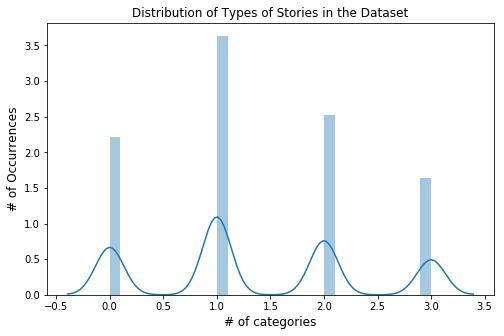

In [132]:
#plot
plt.figure(figsize=(8,5))
ax = sns.distplot(df_train['SECTION'])
plt.title("Distribution of Types of Stories in the Dataset")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

There are four distinct sections where each story may fall in to. The Sections are labelled as follows :
* Politics: 0
* Technology: 1 (the most prevalent cateogory in the given dataset)
* Entertainment: 2 
* Business: 3

#### Text Preprocessing:

In [133]:
def clean_text_data(text):
    """ Function to clean the text of misleaning characters and even out it's representation
        in the feature space.
    """
    text = text.str.lower()
    text = text.str.replace(r'\r', ' ')
    text = text.str.replace(r'\n', ' ')
    text = text.str.replace('[^a-zA-Z0-9 ]', '')
    return text

In [134]:
def nlp_processing(doc): 
    """ Limiting the words to their base form."""
    words = [lemmatizer.lemmatize(word) for word in doc.split() if word not in stop_words]
    doc = ' '.join(words)
    return doc

In [135]:
# Cleaning the training data
df_train['STORY'] = clean_text_data(df_train['STORY'])
df_train['STORY'] = df_train['STORY'].apply(nlp_processing)
# Cleaning the test data
df_test['STORY'] = clean_text_data(df_test['STORY'])
df_test['STORY'] = df_test['STORY'].apply(nlp_processing)

#### Conversion of text data to numerical features

In [136]:
X = df_train['STORY']
y = df_train['SECTION']

In [137]:
x_train, x_eval, y_train, y_eval = train_test_split(X,y, test_size = 0.2, shuffle = True)

In [138]:
tfidf_vec = TfidfVectorizer(stop_words = stop_words)
tfidf_vec.fit(X)
x_vec = tfidf_vec.transform(X)
x_train_vec = tfidf_vec.transform(x_train)
x_eval_vec = tfidf_vec.transform(x_eval)

#### SVM Classification

In [155]:
svc = LinearSVC(C=10, penalty = 'l2',tol = 1e-3, max_iter = 1000)
print((cross_val_score(svc,x_vec,y, cv = 7, verbose = False)).mean())

0.9783692949656926


In [156]:
svc = LinearSVC(C=10)
svc.fit(x_train_vec,y_train)
y_preds = svc.predict(x_eval_vec)

In [157]:
confusion_matrix(y_eval,y_preds)

array([[361,   5,   6,   2],
       [  3, 539,   9,   1],
       [  0,   0, 355,   0],
       [  1,   6,   1, 237]])

#### Multinomial Naive Bayes Classification

In [110]:
mnb = MultinomialNB(alpha=1e-2, fit_prior=True, class_prior=None)
print((cross_val_score(mnb,x_vec,y, cv = 7, verbose = False)).mean())

0.9736503546372679


In [111]:
mnb.fit(x_train_vec,y_train)
y_preds = mnb.predict(x_eval_vec)

In [112]:
confusion_matrix(y_eval,y_preds)

array([[330,   3,   1,   3],
       [  5, 529,   3,   8],
       [ 10,   8, 375,   0],
       [  1,   0,   0, 250]])

As our aim is to maximize the diagonal elements, the performance of the Linear SVM model and Multinomial Naive Bayes are accepteble.

#### LSTM Classification:
Model was not chosen for classification on the test data due to low accuracy score than traditional models

In [57]:
# Keras Imports
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dropout, Dense,Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [79]:
X = df_train['STORY']
y = df_train['SECTION']
x_train, x_eval, y_train, y_eval = train_test_split(X,y, test_size = 0.2, shuffle = True)

In [80]:
vocab_size = 40000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X)

In [81]:
max_len = max([len(s.split()) for s in df_train['STORY']])

In [82]:
train_sequences = tokenizer.texts_to_sequences(x_train)
train_data = pad_sequences(train_sequences, maxlen=50)

In [83]:
val_sequences = tokenizer.texts_to_sequences(x_eval)
val_data = pad_sequences(val_sequences, maxlen=50)

In [84]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_eval = np_utils.to_categorical(y_eval)

In [88]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=50))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='tanh'))
model.add(MaxPooling1D(pool_size=4))
model.add(CuDNNLSTM(32))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [89]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 32)            1280000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 64)            10304     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 1,302,980
Trainable params: 1,302,980
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.fit(train_data, y_train, epochs=5, validation_data = (val_data,y_eval),verbose = True)

Train on 6102 samples, validate on 1526 samples
Epoch 1/5
6102/6102 [==============================] - 2s 328us/step - loss: 0.6628 - acc: 0.7319 - val_loss: 0.1934 - val_acc: 0.9345
Epoch 2/5
6102/6102 [==============================] - 1s 184us/step - loss: 0.0932 - acc: 0.9741 - val_loss: 0.1537 - val_acc: 0.9476
Epoch 3/5
6102/6102 [==============================] - 1s 185us/step - loss: 0.0249 - acc: 0.9941 - val_loss: 0.1625 - val_acc: 0.9567
Epoch 4/5
6102/6102 [==============================] - 1s 188us/step - loss: 0.0120 - acc: 0.9971 - val_loss: 0.1835 - val_acc: 0.9528
Epoch 5/5
6102/6102 [==============================] - 1s 186us/step - loss: 0.0104 - acc: 0.9972 - val_loss: 0.1839 - val_acc: 0.9541


#### Submission:

In [91]:
# Training the model on whole data
svc = LinearSVC(C=10)
svc.fit(x_vec,y)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
x_test_vec = tfidf_vec.transform(df_test['STORY'])

In [ ]:
test_predictions = svc.predict(x_test_vec)

In [ ]:
submission_df = pd.DataFrame(test_predictions)
submission_df.to_excel('submission.xlsx', index=False,header = ['SECTION'])